In [1]:
%load_ext autoreload
%autoreload 2

import anndata as ad
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
from mmd_wrapper.utilities import alignment_visualize, pairwise_error
import numpy as np
import pandas as pd

from commando import ComManDo

2021-11-17 10:23:45.069954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 10:23:45.069985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


# Read Data

In [2]:
data_mod1 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod1.h5ad')
data_mod2 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod2.h5ad')

In [12]:
cell_cycle_genes = [x.strip() for x in open('REGEV/cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [19]:
data_mod1.var

,gene_ids,feature_types
MORN1,ENSG00000116151,GEX
RPL22,ENSG00000116251,GEX
KDM1A,ENSG00000004487,GEX
GPN2,ENSG00000142751,GEX
PTP4A2,ENSG00000184007,GEX
...,...,...
MT-CO2,ENSG00000198712,GEX
MT-CO3,ENSG00000198938,GEX
MT-ND3,ENSG00000198840,GEX
MT-ND4,ENSG00000198886,GEX


# Run Mapping

In [34]:
commando_optimized = (
    ComManDo(
        distance_mode='euclidean',
        epoch_pd=500,
        log_pd=500,
        two_step_aggregation = 'cell_cycle',
        two_step_aggregation_kwargs = {
            's_genes': s_genes,
            'g2m_genes': g2m_genes,
        },
        two_step_pd_large=2000,
        # two_step_include_large=False,
        two_step_log_pd=2,
        # two_step_num_partitions=5,
        # two_step_redundancy=2,
    )
    .fit_transform([data_mod1, data_mod2])
)

use random seed: 666
Two-Step group sizes
Min: 74
Max: 346
Shape of Raw data
Dataset 0: (500, 600)
Dataset 1: (500, 600)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 1
Calculating intra-group F #2
epoch:[500/500] err:0.3721 alpha:0.9376
Calculating inter-group F
epoch:[500/2000] err:0.9487 alpha:0.0148
epoch:[1000/2000] err:1.0565 alpha:0.0137
epoch:[1500/2000] err:1.1806 alpha:0.0131
epoch:[2000/2000] err:1.3012 alpha:0.0127
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
Calculating intra-group F #2
epoch:[500/500] err:1.6240 alpha:5.4365
Calculating inter-group F
epoch:[500/2000] err:1.6798 alpha:0.0408
epoch:[1000/2000] err:2.0736 alpha:0.0501
epoch:[1500/2000] err:2.3514 alpha:0.0564
epoch:[2000/2000] err:2.5139 alpha:0.0602
---------------------------------
Find correspondence between Dataset 2 and Dataset 2
Calculating intra-group F #2
epoch:[500/500] err:1.2847 alpha:0.9538
Calculating inte

In [35]:
commando_normal = (
    ComManDo(
        distance_mode='euclidean',
        epoch_pd=2000,
        log_pd=1000,
    )
    .fit_transform([X1, X2])
)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 600)
Dataset 1: (500, 600)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 1
epoch:[1000/2000] err:0.2451 alpha:0.7782
epoch:[2000/2000] err:0.2526 alpha:0.9008
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[1000/2000] err:0.9675 alpha:4.7533
epoch:[2000/2000] err:0.9727 alpha:5.5065
---------------------------------
Find correspondence between Dataset 2 and Dataset 2
epoch:[1000/2000] err:0.7438 alpha:0.7918
epoch:[2000/2000] err:0.6264 alpha:0.9178
Finished Matching!
---------------------------------
Performing NLMA
Constructing Dense W
Applying Coefficients
Computing Laplacian
Calculating eigenvectors
Filtering eigenvectors
Perfoming mapping
---------------------------------
ComManDo Done!
Time: 26.6005699634552 seconds


# Evaluate

ComManDo Optimized Pairwise Error: 3.7582590957172215
ComManDo Normal Pairwise Error:    6.3064546523673926


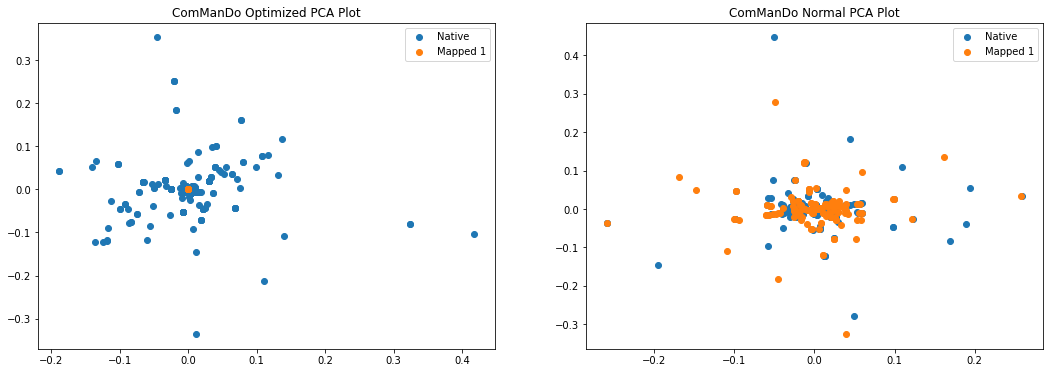

In [36]:
print('ComManDo Optimized Pairwise Error: ' + str(pairwise_error(*commando_optimized, normalize_by_feature=True)))
print('ComManDo Normal Pairwise Error:    ' + str(pairwise_error(*commando_normal, normalize_by_feature=True)))

plt.subplots(figsize=(18, 6))
plt.subplot(1, 2, 1)
alignment_visualize(*commando_optimized, alg_name='ComManDo Optimized')

plt.subplot(1, 2, 2)
alignment_visualize(*commando_normal, alg_name='ComManDo Normal')